In [1]:
import requests
from lxml import etree
import os
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium import webdriver
from fake_useragent import UserAgent
from selenium_stealth import stealth
import time,random
import re

In [2]:
BASE_URL = 'https://www.maoyan.com/films'##爬取的网站
HOME_URL = 'https://www.maoyan.com'
headers={
            'Content-Type': 'text/plain; charset=UTF-8',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36',
            # 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36',
            'Cookie': '__mta=208959789.1585106920033.1593509077842.1593509107607.47; _lxsdk_cuid=1710fbc224bc8-0048503dcb84eb-f313f6d-1a298c-1710fbc224cc8; mojo-uuid=bc73035186bc203e1e0a1a9d69cf0c8f; uuid_n_v=v1; uuid=010A4750BAB111EA977B252D9527D646FCA82B59C6B54FB3934C361D719643F2; _csrf=ab7e60b187089a5c797755f042abdbd14eed1760f8308dc455570ee9ea4edfa2; mojo-session-',
            'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9'
        }



In [3]:
def get_html(url,params = None):
    response = requests.get(url = url,params=params,headers=headers)##请求网页
    response.encoding = 'utf-8'
    html = response.text##获取页面源码
    return html

In [4]:
def film_page_url(url,params = None):
    html = get_html(url,params)
    tree = etree.HTML(html)##etree解析
    film_url_list = tree.xpath('//div[@class="movie-item film-channel"]/a/@href')#xpath解析
    film_url_list = [HOME_URL + url for url in film_url_list]
    return film_url_list
 

In [5]:
url_list = []
for i in range(200):
    params = {
    'showType':3,
    'offset': i * 30
    }
    url_list += film_page_url(url=BASE_URL,params=params)

In [6]:
len(url_list)

2010

In [7]:
service = Service('./chromedriver-win64/chromedriver.exe')
options = webdriver.ChromeOptions()
# 反爬虫关键配置
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)
options.add_argument('--disable-infobars')
options.add_argument('--disable-notifications')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

fake_ua = UserAgent().random
options.add_argument(f'--user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36"')
print(fake_ua)
browser = webdriver.Chrome(service=service,options=options)
# 使用stealth模式隐藏自动化特征
stealth(browser,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

# 随机延迟访问
time.sleep(random.uniform(1, 3))

Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36


In [8]:
feature_dic = {
    'movie_name':[],
    'movie_tag':[],
    'movie_country':[],
    'movie_length':[],
    'movie_release':[],
    'movie_rate':[],
    'movie_summary':[],
    'movie_director':[],
    'movie_actor':[],
    'movie_rank':[],
    'movie_firtweek_ticket':[],
    'movie_all_ticket':[],
}


In [9]:
def getMovieFeature(url):
    browser.get(url)
    browser.implicitly_wait(10)
    ##获取电影名字
    try:
        movie_name = browser.find_element(by=By.XPATH,value='//div[@class="movie-brief-container"]/h1').text
    except:
        movie_name = 'Unknown'

    ##获取电影标签
    try:
        movie_tag = browser.find_element(by=By.XPATH,value='//div[@class="movie-brief-container"]/ul/li[1]').text
        movie_tag = movie_tag.replace(' ','-')
    except:
        movie_tag = 'Unknown'

    ##获取影片时长和国家
    try:
        movie_information = browser.find_element(by=By.XPATH,value='//div[@class="movie-brief-container"]/ul/li[2]').text
        movie_country = movie_information.split('/')[0]

        movie_length = movie_information.split('/')[1]
        pattern = re.compile(r'\d+')##匹配数字
        movie_length = pattern.search(movie_length).group()##只获取分钟数
    except:
        movie_country = 'Unknown'
        movie_length = 'Unknown'


    ##获取电影上映时间
    try:
        movie_release = browser.find_element(by=By.XPATH,value='//div[@class="movie-brief-container"]/ul/li[3]').text
        movie_release = movie_release[:10]
    except:
        movie_release = 'Unknown'

    ##获取电影评分
    try:
        movie_rate = browser.find_element(by=By.XPATH,value='//div[@class="star-wrapper"]/div').get_attribute('style')
        movie_rate = pattern.search(movie_rate).group()
    except:
        movie_rate = 'Unknown'

    ##获取电影简介
    try:
        movie_summary = browser.find_element(by=By.XPATH,value='//div[@class="mod-content"]/span').text
    except:
        movie_summary = 'Unknown'

    ##获取导演信息
    try:
        movie_director = browser.find_element(by=By.XPATH,value='//div[@class="celebrity-group"]/ul/li/div[@class="info"]/div').text
    except:
        movie_director = 'Unknown'

    ##获取演员信息
    movie_actor_list = browser.find_elements(by=By.XPATH,value='//div[@class="celebrity-group"][2]/ul/li')
    movie_actor = []
    if movie_actor_list:
        for div in movie_actor_list:
            acotr = div.find_element(by=By.XPATH,value='./div[@class="info"]/div[1]').text
            if acotr:
                movie_actor.append(acotr)
        movie_actor = '-'.join(movie_actor)
    else:
        movie_actor = 'Unknown'
        


    ##获取电影票房情况(昨日排名,首周,总 or 首周,总)
    film_ticketBox = browser.find_elements(by=By.XPATH,value='//div[@class="film-mbox"]/div')

    ##如果有昨日排名
    if len(film_ticketBox) == 3:
        movie_rank = browser.find_element(by=By.XPATH,value='//div[@class="film-mbox"]/div[1]/div[1]').text
        ##获取首周票房
        movie_firtweek_ticket = browser.find_element(by=By.XPATH,value='//div[@class="film-mbox"]/div[2]/div[1]').text
        ##获取总票房
        movie_all_ticket = browser.find_element(by=By.XPATH,value='//div[@class="film-mbox"]/div[3]/div[1]').text

    ##如果没有昨日排名
    elif len(film_ticketBox) == 2:
        movie_rank = 'Unknown'
        ##获取首周票房
        movie_firtweek_ticket = browser.find_element(by=By.XPATH,value='//div[@class="film-mbox"]/div[1]/div[1]').text
        ##获取总票房
        movie_all_ticket = browser.find_element(by=By.XPATH,value='//div[@class="film-mbox"]/div[2]/div[1]').text
    
    else:
        movie_rank = 'Unknown'
        ##获取首周票房
        movie_firtweek_ticket = 'Unknown'
        ##获取总票房
        movie_all_ticket = 'Unknown'

    feature_dic['movie_name'].append(movie_name)
    feature_dic['movie_tag'].append(movie_tag)
    feature_dic['movie_country'].append(movie_country)
    feature_dic['movie_length'].append(movie_length)
    feature_dic['movie_release'].append(movie_release)
    feature_dic['movie_rate'].append(movie_rate)
    feature_dic['movie_summary'].append(movie_summary)
    feature_dic['movie_director'].append(movie_director)
    feature_dic['movie_actor'].append(movie_actor)
    feature_dic['movie_firtweek_ticket'].append(movie_firtweek_ticket)
    feature_dic['movie_all_ticket'].append(movie_all_ticket)
    feature_dic['movie_rank'].append(movie_rank)

In [10]:
feature_dic = {
    'movie_name':[],
    'movie_tag':[],
    'movie_country':[],
    'movie_length':[],
    'movie_release':[],
    'movie_rate':[],
    'movie_summary':[],
    'movie_director':[],
    'movie_actor':[],
    'movie_rank':[],
    'movie_firtweek_ticket':[],
    'movie_all_ticket':[],
    }
# def main(total_page):
#     film_url_list = []
#     for i in range(total_page):
#         params = {
#         'showType':3,
#         'offset': i * 30
#         }
#         film_url_list += film_page_url(url=BASE_URL,params=params)




In [11]:
total_len = len(url_list)
for i, film_url in enumerate(url_list):
    print(f'第{i}个页面，共{total_len}个')
    try:
        getMovieFeature(film_url)
    except:
        continue

第0个页面，共2010个
第1个页面，共2010个
第2个页面，共2010个
第3个页面，共2010个
第4个页面，共2010个
第5个页面，共2010个
第6个页面，共2010个
第7个页面，共2010个
第8个页面，共2010个
第9个页面，共2010个
第10个页面，共2010个
第11个页面，共2010个
第12个页面，共2010个
第13个页面，共2010个
第14个页面，共2010个
第15个页面，共2010个
第16个页面，共2010个
第17个页面，共2010个
第18个页面，共2010个
第19个页面，共2010个
第20个页面，共2010个
第21个页面，共2010个
第22个页面，共2010个
第23个页面，共2010个
第24个页面，共2010个
第25个页面，共2010个
第26个页面，共2010个
第27个页面，共2010个
第28个页面，共2010个
第29个页面，共2010个
第30个页面，共2010个
第31个页面，共2010个
第32个页面，共2010个
第33个页面，共2010个
第34个页面，共2010个
第35个页面，共2010个
第36个页面，共2010个
第37个页面，共2010个
第38个页面，共2010个
第39个页面，共2010个
第40个页面，共2010个
第41个页面，共2010个
第42个页面，共2010个
第43个页面，共2010个
第44个页面，共2010个
第45个页面，共2010个
第46个页面，共2010个
第47个页面，共2010个
第48个页面，共2010个
第49个页面，共2010个
第50个页面，共2010个
第51个页面，共2010个
第52个页面，共2010个
第53个页面，共2010个
第54个页面，共2010个
第55个页面，共2010个
第56个页面，共2010个
第57个页面，共2010个
第58个页面，共2010个
第59个页面，共2010个
第60个页面，共2010个
第61个页面，共2010个
第62个页面，共2010个
第63个页面，共2010个
第64个页面，共2010个
第65个页面，共2010个
第66个页面，共2010个
第67个页面，共2010个
第68个页面，共2010个
第69个页面，共2010个
第70个页面，共2010个
第71个页面，共2010个
第7

In [369]:
main(100)

In [14]:
import pandas as pd
df = pd.DataFrame(feature_dic)
df.to_csv('movieFeature.csv')

<Axes: >

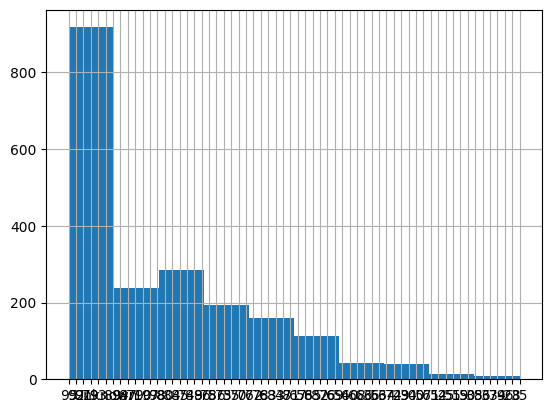

In [17]:
df['movie_rate'].hist()